In [2]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from tbcontrol.symbolic import routh

In [3]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [4]:
s = ctl.TransferFunction.s
G = 1/(1.59154943091895*s + 1.0)

G_bkp = G
G

TransferFunction(array([1]), array([1.59154943, 1.        ]))

polos:  (-0.628+0j)
zeros: 


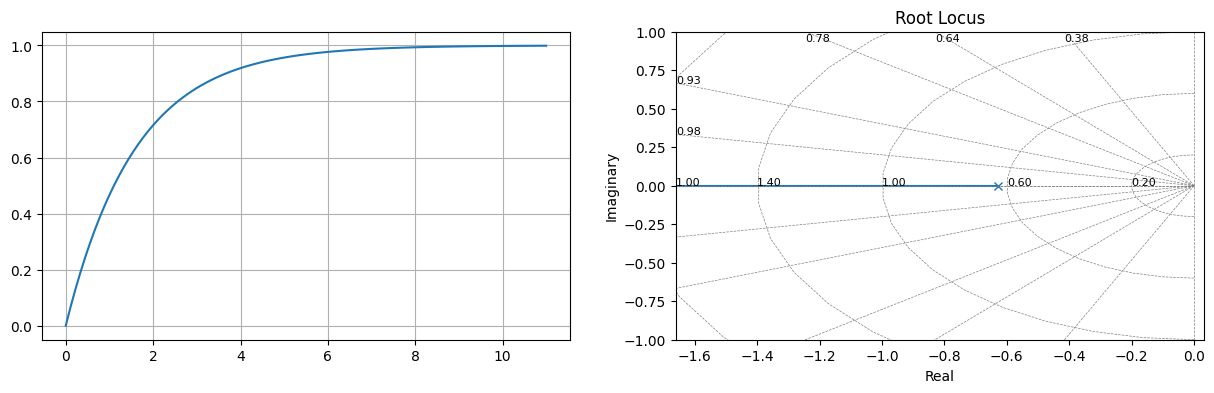

In [5]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# INFORMAÇÕES DA RESPOSTA

In [6]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 0.9990000000000006,
 'peakTime': 10.994033983191393,
 'settlingTime': 5.663593264068293,
 'finalValue': 0.9990000000000006,
 'error': 0.0009999999999994458}

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K_p \, \big(1 + \frac{1}{T_is}\big)\big(\frac{T_ds + 1}{0.1T_ds + 1}\big)$

In [7]:
s = ctl.TransferFunction.s

In [8]:
def getResponsePID(Kp, Ti, Td):
    C     = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
    G_ma = G*C

    error = 1/(1 + G_ma(0.00001))

    if error > 0.1:
        return None

    time, response = ctl.step_response(ctl.feedback(G_ma, 1), T=np.linspace(0, 5, 100))
    data = getAllInfo(time, response, show=False)

    if data.get('settlingTime') is None:
        return None
    
    data['Kp'] = Kp
    data['Ti'] = Ti
    data['Td'] = Td
    return data


In [9]:
Kp_data = np.linspace(0.01, 100, 10)
Ti_data = np.linspace(0.01, 5, 10)
Td_data = np.linspace(0.01, 5, 10)

In [10]:
data = []

for Kp in Kp_data:
    for Ti in Ti_data:
        for Td in Td_data:
            response = getResponsePID(Kp, Ti, Td)

            if response is None:
                continue
            
            data.append(response)

In [11]:
df = pd.DataFrame(data)
df

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.002363,1.029696,4.444444,3.030303,1.027269,0.027269,0.01,0.01,1.118889
1,0.000000,0.993376,5.000000,2.878788,0.993376,0.006624,0.01,0.01,1.673333
2,0.000000,0.974493,5.000000,2.676768,0.974493,0.025507,0.01,0.01,2.227778
3,0.000000,0.963593,5.000000,1.717172,0.963593,0.036407,0.01,0.01,2.782222
4,0.123892,1.066217,1.363636,3.131313,0.948682,0.051318,0.01,0.01,5.000000
...,...,...,...,...,...,...,...,...,...
900,0.000000,0.996111,5.000000,0.050505,0.996111,0.003889,100.00,5.00,2.782222
901,0.000000,0.996139,5.000000,0.050505,0.996139,0.003861,100.00,5.00,3.336667
902,0.000000,0.996220,5.000000,0.050505,0.996220,0.003780,100.00,5.00,3.891111
903,0.000000,0.996329,5.000000,0.050505,0.996329,0.003671,100.00,5.00,4.445556


### ANÁLISE DOS DADOS

In [12]:
Ts = 1.0
UP = 0.5

In [13]:
target = df.loc[df['settlingTime'] < Ts]
target

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
5,0.461136,1.461136,0.101010,0.555556,1.000000,2.220446e-15,11.12,0.01,0.010000
6,0.084670,1.084670,0.050505,0.101010,1.000000,3.727598e-07,11.12,0.01,0.564444
7,0.083627,1.083630,0.050505,0.101010,1.000004,3.537384e-06,11.12,0.01,1.118889
8,0.083076,1.083075,0.050505,0.101010,0.999999,1.199433e-06,11.12,0.01,1.673333
9,0.082768,1.082756,0.050505,0.101010,0.999989,1.105420e-05,11.12,0.01,2.227778
...,...,...,...,...,...,...,...,...,...
900,0.000000,0.996111,5.000000,0.050505,0.996111,3.889320e-03,100.00,5.00,2.782222
901,0.000000,0.996139,5.000000,0.050505,0.996139,3.861396e-03,100.00,5.00,3.336667
902,0.000000,0.996220,5.000000,0.050505,0.996220,3.780302e-03,100.00,5.00,3.891111
903,0.000000,0.996329,5.000000,0.050505,0.996329,3.671448e-03,100.00,5.00,4.445556


In [14]:
target = target.loc[target['overshoot'] == target['overshoot'].min()]
target

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
18,0.0,0.999876,5.0,0.707071,0.999876,0.000124,11.12,0.564444,1.673333
19,0.0,0.999124,5.0,0.505051,0.999124,0.000876,11.12,0.564444,2.227778
20,0.0,0.998494,5.0,0.252525,0.998494,0.001506,11.12,0.564444,2.782222
21,0.0,0.998036,5.0,0.101010,0.998036,0.001964,11.12,0.564444,3.336667
22,0.0,0.997725,5.0,0.101010,0.997725,0.002275,11.12,0.564444,3.891111
...,...,...,...,...,...,...,...,...,...
900,0.0,0.996111,5.0,0.050505,0.996111,0.003889,100.00,5.000000,2.782222
901,0.0,0.996139,5.0,0.050505,0.996139,0.003861,100.00,5.000000,3.336667
902,0.0,0.996220,5.0,0.050505,0.996220,0.003780,100.00,5.000000,3.891111
903,0.0,0.996329,5.0,0.050505,0.996329,0.003671,100.00,5.000000,4.445556


In [15]:
row = target.iloc[0].to_dict()
Kp, Ti, Td = row['Kp'], row['Ti'], row['Td']
Kp, Ti, Td

(11.12, 0.5644444444444445, 1.6733333333333336)

# RESPOSTA CONTROLADA

In [16]:
s  = ctl.TransferFunction.s

C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
C

TransferFunction(array([10.50288119, 24.88408889, 11.12      ]), array([0.09445037, 0.56444444, 0.        ]))

In [17]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([10.50288119, 24.88408889, 11.12      ]), array([0.15032243, 0.9927916 , 0.56444444, 0.        ]))

In [18]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([10.50288119, 24.88408889, 11.12      ]), array([ 0.15032243, 11.49567279, 25.44853333, 11.12      ]))

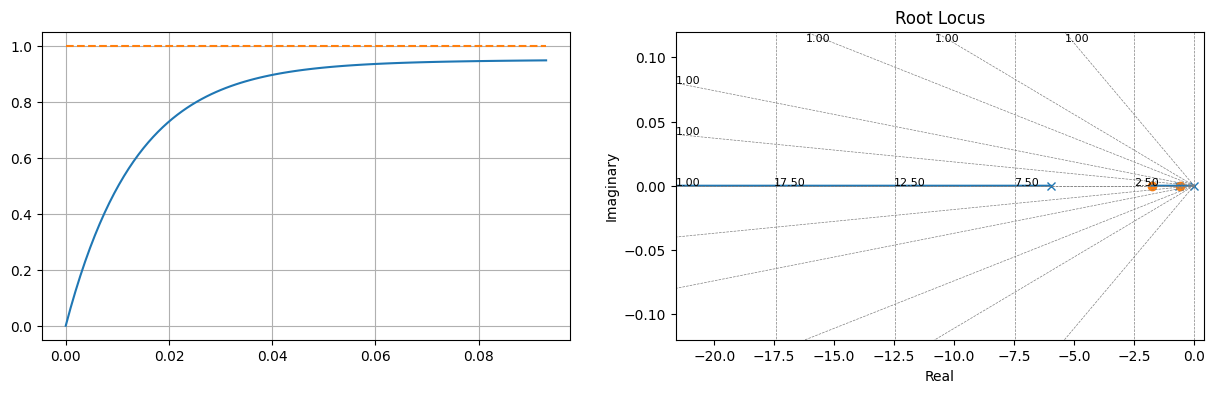

In [19]:
time, response = ctl.step_response(G_feedback)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)

plt.show()

In [20]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  0.9477219812526609
tempo de pico:  0.09308958214365796
tempo de assentamento:  0.04889553809565873
valor final:  0.9477219812526609
erro:  0.05227801874733906


# APLICANDO VÁRIOS STEPS

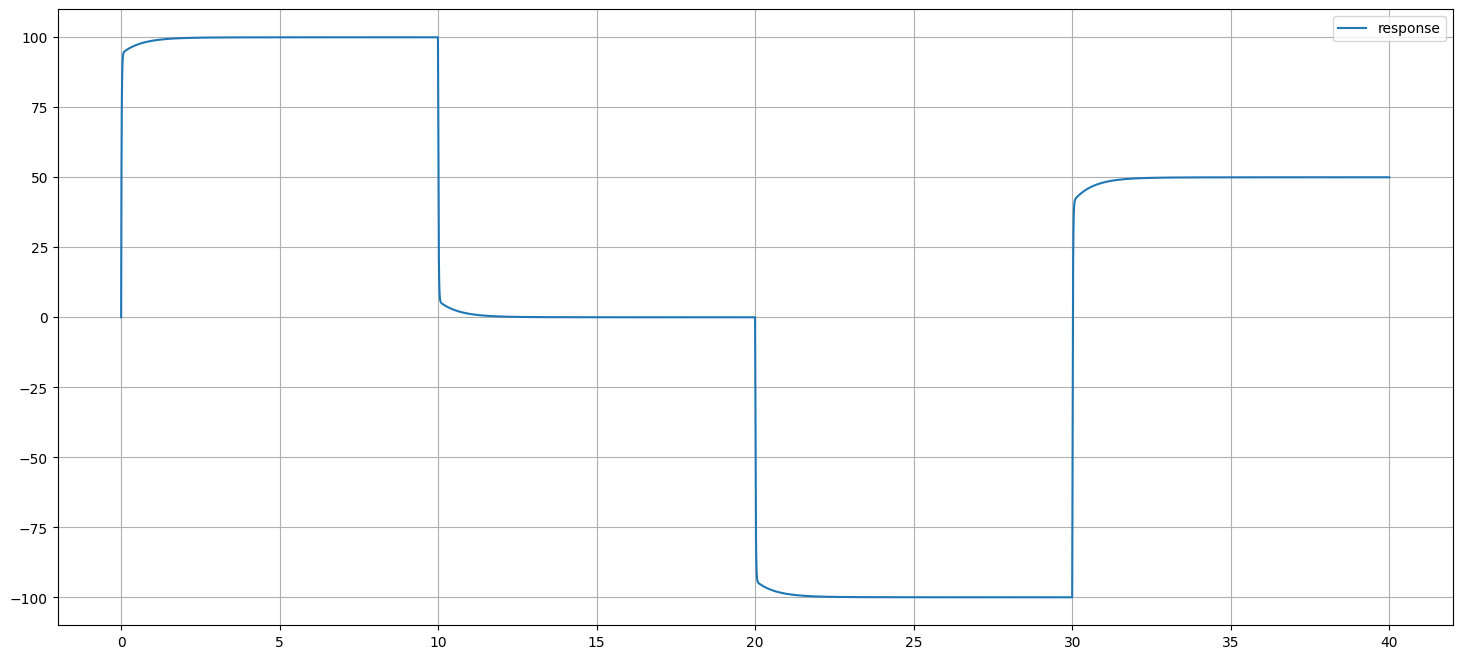

In [21]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()